# TVD advection solver and related functions

*(Greg Tucker, first written March 2023)*

This notebook reviews Landlab tools for solving advection equations numerically. The tools include the `AdvectionSolverTVD` component and related functions. `AdvectionSolverTVD` provides a second-order, total variation diminishing (TVD) numerical finite-volume solution to the 2D advection equation. The component requires a structured grid (raster or hex). The component can advect any node-based field or array. The user needs to provide a link-based advection velocity field.

## Overview of new functions

Second-order TVD methods require evaluation of gradients "upwind" of a given location, where "upwind" means in the direction opposite to the advection direction. To facilitate this, Landlab's `components.advection` package includes the following functions:

- `find_upwind_link_at_link`: for each link, identifies the adject parallel link that lies in the upwind direction. This function makes use of the raster- and hex-based property `parallel_links_at_link`, which is a (number-of-links x 2) data structure that records the IDs of adjacent parallel links that lie in the tail-wise (elements [:,0]) and head-wise (elements [:,1]) directions.
- `upwind_to_local_grad_ratio`: for each link, calculates the ratio of gradient of given node scalar at the upwind link (if it exists) to the gradient at local link. For links that lack an upwind link (e.g., upwind would be beyond the grid boundary), or those where the local gradient is zero, a value of 1 is assigned. (Note that links along a grid boundary are considered not to have an upwind link.)

TVD methods also require the use of a "flux limiter" function, which takes the upwind-to-local gradient ratio as an input, and returns a weighting factor that sets the relative contribution of high-order to low-order terms (see below). Many flux limiter functions have been proposed. As of this writing, Landlab's advection package includes just one: `flux_lim_vanleer`, which can be imported from `landlab.advection.flux_limiters`.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Theory

The `AdvectionSolverTVD` and related support functions provide second-order TVD models for 2D advection. Here we briefly review the theory using a 1D advection equation with state variable $z$:

$$\frac{\partial z}{\partial t} = -u \frac{\partial z}{\partial x}$$

where $t$ is time, $x$ is spatial position in 1D, and $u$ is advection velocity (positive in the $x$ direction). This type of equation comes in up in numerous contexts in Earth and environmental sciences. The right-hand side is an *advection term*; often such terms appear in combination with other terms, such as diffusion or source. (See for example Slingerland and Kump *Mathematical Modeling of Earth's Dynamical Systems* (2011)).

To learn more about numerical solutions to advection problems, I highly recommend a series of online videos by Dr. Hilary Weller in the Meteorology Department at the University of Reading.


### Discretizing the advection equation

A common discretization involves solving $z$ at a set of *nodes*, which we'll indicate with a subscript $j$, so that $z_j$ refers to the value of $z$ at node $j$. We'll use superscripts to denote time step, so that $z_j^n$ means the value of $z$ at node $j$ and time step $n$. Using a first-order forward-difference time discretization, the discretized 1D advection equation can be written as:

$$\frac{z_j^{n+1}-z_j^n}{\Delta t} = -u \frac{z_{j+1/2} - z_{j-1/2}}{\Delta x}$$

where $\Delta x$ is the spacing between nodes. Note that we've omitted the time-step superscript on the right side; for purposes of this example, we'll assume it is $n$, indicating an explicit solution, where not otherwise noted.

We can rearrange this equation to solve for the future quantity as:

$$z_j^{n+1} = z_j -c( z_{j+1/2} - z_{j-1/2} )$$

where $c$ is a dimensionless parameter known as the Courant number:

$$c = \frac{u\Delta t}{\Delta x}$$

Note that $c$ has the same sign as $u$.

### Second-order Total Variation Diminishing scheme

One of the challenges in solving advection problems discretized as above is defining what $j+1/2$ or $j-1/2$ means. If we imagine that each node sits inside a cell of width $\Delta x$, then index $j+1/2$ refers to the interface between the cells that contain nodes $j$ and $j+1$. The sketch below shows two nodes (indicated by a dot), labeled $j$ and $j+1$, with the ^ mark showing the interface at location $j+1/2$:

```
-------------
|  .  |  .  |
-------------
   j  ^ j+1
    j+1/2
```

One approach is to use a *first-order upwind* method, in which we assign to location $z_{j+1/2}$ either the value $z_j$ or $z_{j+1}$, depending on which is "upwind" (in the direction opposite to that implied by $u$). If $u>0$, we would assign $z_j$; if $u<0$, we would assign $z_{j+1}$. Mathematically, this can be written:

$$z_{j+1/2} = z_j \text{ if } c\ge0, z_{j+1} \text{otherwise}$$

The problem with first-order upwind schemes is that they tend to produce excessive smoothing. One solution is to use a *linear second-order advection scheme*. One such scheme is the well-known Lax-Wendroff method, which assigns a weighted average of $z_j$ and $z_{j+1}$ based on the Courant number:

$$z_{j+1/2} = \frac{1}{2}(1+c)z_j + \frac{1}{2} (1-c)z_{j+1}$$

However, linear second-order methods generate spurious oscillations in the solution. Lax-Wendroff solutions tend to be smooth ahead of a discontinuity but generates oscillations behind it. The Warming and Beam method:

$$z_{j+1/2} = \frac{1}{2}(3-c)z_j - \frac{1}{2} (1-c)z_{j-1}$$

has the opposite problem, with smoothness behind but oscillations ahead.

These oscillation represent an increase in the *total variation*, which in this discrete formulation is the sum of $|z_j - z_{j+1}|$, i.e., the sum of all variations in adjacent values of $z$.

To ensure *Total Variation Diminishing*, we can calculate $z_{j+1/2}$ as a weighted average of a *high-order flux* $z_H$ and a *low-order flux* $z_L$:

$$z_{j+1/2} = \Psi_{j+1/2} z_H + (1-\Psi_{j+1/2}) z_L$$

The low-order flux is just the linear upwind solution:

$$z_{L,j+1/2} = z_j \text{ if } c\ge0, z_{j+1} \text{otherwise}$$

For the high-order flux, Lax-Wendroff is a good choice:

$$z_{H,j+1/2} = \frac{1}{2}(1+c)z_j + \frac{1}{2} (1-c)z_{j+1}$$

$\Psi$ is called a *flux limiter* function. The idea is to use $z_H$ as much as possible. In particular, have $\Psi$ approach 1 where the solution is smooth, and approach zero where the solution is changing fast. This is a nonlinear method because $\Psi$ depends on $\phi$.

It turns out to be useful to define $\Psi$ in terms of a variable called $r$, which represents the ratio of the upwind gradient to the local gradient. For $u>0$,

$$r_{j+1/2} = \frac{z_j - z_{j-1}}{z_{j+1}-z_j}$$

and for $u<0$

$$r_{j+1/2} = \frac{z_{j+2} - z_{j+1}}{z_{j+1}-z_j}$$

(Note: I have not found a source that describes what to do when the denominator is zero. From Campforts et al. (2017) it looks as they set $r=1$ when that happens.)

One can cast $\Psi$ as a function of $r$. There are constraints on doing this to ensure TVD (summarized [here](https://en.wikipedia.org/wiki/Flux_limiter)). There are lots of these flux limiter functions. As of this writing, the one used in `AdvectionSolverTVD` is called Van Leer:

$$\Psi(r) = \frac{r+|r|}{1+|r|}$$

Practically speaking, one needs to compute gradients locally and at the upwind locations in order to calculate $r$, then calculate the flux limiter $\Psi$ for each pair of adjacent nodes. After computing $z_H$ and $z_L$ for each pair of nodes, you calculate the weighted averages using $\Psi$. Once that's done, you calculate the solution to the difference equation above to get the value of $z$ at each node for the new time step. As described below, the `AdvectionSolverTVD` takes advantage of Landlab's node-link geometry to do these calculations.

## Numerical implementation on a Landlab grid

In translating the second-order TVD scheme above onto a Landlab structured grid, it's important to note that the discretized advection equation can be cast as a conservation-law problem. For the sake of a concrete example, suppose we are interested in the tectonic advection of topography through a fixed grid. The volume of material inside a grid cell $j$ with area $a_j$ is its average height, $z_j$, times the area. Along each face $k$ of the cell, material is being advected in at a rate of $Q_k$ cubic meters per year. If $Q_k$ is negative, it means that material is being carried out of the cell at that face. The rate of change of volume is:

$$\frac{\partial a_jz_j}{\partial t} = \sum_{k=1}{N_j} Q_k$$

Let $\lambda$ represent the length of a cell *face*. We can use this to express volume flux in terms of volume per face length, $q_k$, times $\lambda$:

$$\frac{\partial a_jz_j}{\partial t} = \sum_{k=1}{N_j} \lambda_k q_k$$

Assuming the cell areas don't change with time,

$$\frac{\partial z_j}{\partial t} = \frac{1}{a_j} \sum_{k=1}{N_j} \lambda_k q_k$$

Landlab already has a built-in function to calculate the right-hand side of this equation: `calc_flux_div_at_node`. The user just needs to provide an array of $q$ values defined at links, and the function then uses the grid geometry ($\lambda$ and $a$) to calculate the resulting rate.

For the topographic advection problem, $q_k$ for any given cell face is the product of $z_k$ and the face-perpendicular advection velocity $u_k$. Because each cell face also has a matching *link* that connects the two nodes in question, the approach used by `AdvectionSolverTVD` is to calculate and store $z_k$, $u_k$, and $q_k$ at the links. Among other things, this means that the user needs to provide face-perpendicular (link-parallel) advection velocities $u_k$.

### Setting up face-perpendicular advection velocities

For a `RasterModelGrid`, assigning face-perpendicular velocities is straightforward. Assuming you know the $x$ and $y$ velocity components, you can simply assign the $x$ component to horizontal links, and the $y$ component to vertical links. For example, if `u` is an at-link velocity array (a required input; see below), `grid` is a `RasterModelGrid`, and `ux` and `uy` are the velocity components, then you can assign the correct link-parallel velocities with:

```
u[grid.horizontal_links] = ux
u[grid.vertical_links] = uy
```

For a `HexModelGrid`, it is a bit more complicated, because the faces don't all align with Cartesian directions. Fortunately, Landlab provides a mapping function called `map_vectors_to_links` to take care of this, illustrated by this example:

```
vel = grid.add_zeros('advection__velocity', at='link')
map_vectors_to_links(grid, ux, uy, out=vel)
```

The function works with raster grids too, so the above code could be used instead for that case as well.

### How `AdvectionSolverTVD` calculates its solution

To calculate a rate of vertical change, the solution algorithm involves these steps:

1. If the advection field is changing in sign/direction, re-identify for each link the link that lies upwind.

2. Use the function `map_node_to_link_linear_upwind` to identify a "low order" value of the advected quantity at each link.

3. For each link, use the function `map_node_to_link_lax_wendroff` to calculate a "high order" value of the advected quantity at each link.

4. Use the function `upwind_to_local_grad_ratio` to calculate the ratio of upwind to local gradient in the advected quantity at each link (applying a value of unity where an upwind link does not exist or the local gradient is zero).

5. From the gradient ratio, use the function `flux_lim_vanleer` to calculate the weighting factor $\Psi$.

6. Using the weighting factor, calculate a value of the advected quantity at the links using a weighted average of the low-order and high-order values.

7. Calculate a flux at each *active* link by multiplying the link-based value of the advected quantity by the link-perpendicular advection velocity.

8. Use the `calc_flux_div_at_node` function to calculate the flux divergence, and return the (negative) value of this as the time rate of change of the advected variable at each (non-perimeter) node.

Calling `update(dt)` or `run_one_step(dt)` (they are synonyms) computes this rate of change and then updates the advected quantity using a forward-Euler step with the given time-step duration `dt`.





In [ ]:
from landlab import RasterModelGrid, HexModelGrid

### Case of a step function advection

TODO: generalise to an upwind_link_at_link, using the sign of c translated into 0, 1 index for tail and head.

In [ ]:
# Functions
def upwind_to_local_grad_ratio(grid, v, c, uwll):
    """
    .
    """
    h = grid.node_at_link_head
    t = grid.node_at_link_tail
    local_diff = v[h] - v[t]
    r = np.ones(grid.number_of_links)

    upwind_exists_and_nonzero_local = np.logical_and(
        uwll != -1,
        local_diff != 0.0
    )

    r[upwind_exists_and_nonzero_local] = (
        local_diff[uwll[upwind_exists_and_nonzero_local]] 
        / local_diff[upwind_exists_and_nonzero_local]
    )
    return r, local_diff, uwll, local_diff[uwll]


In [ ]:
# Tests of upwind_to_local_grad_ratio
grid = RasterModelGrid((4, 4))
v = grid.add_zeros('value', at='node')
v[:] = np.arange(grid.number_of_nodes)**2
print(v.reshape(4,4))

# Predicted upwind_to_local_grad_ratio for u>1
#
# Link  Local grad  Upwind link  Upwind diff  Ratio
#  0 (n/a)
#  1 (n/a)
#  2 (n/a)
#  3 (n/a)
#  4    24          none         n/a          1
#  5    32          none         n/a          1
#  6 (n/a)
#  7     9          none         n/a          1
#  8    11          7             9           9/11
#  9    13          8            11           11/13
# 10 (n/a)
# 11    56          4            24           24/56
# 12    64          5            32           1/2
# 13 (n/a)
# 14    17          none         n/a          1
# 15    19          14           17           17/19
# 16    21          15           19           19/21
# 17 (n/a)
# 18    88          11           56           56/88
# 19    96          12           64           64/96
# 20 (n/a)
# 21 (n/a)
# 22 (n/a)
# 23 (n/a)

#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, 1.0) #, pll)
print(uwll)
r, ld, uwl, lduw = upwind_to_local_grad_ratio(grid, v, c, uwll)
for k in grid.active_links:
    print(k, ld[k], uwl[k], ld[uwl[k]], r[k])

In [ ]:
r

In [ ]:
# Parameters
u = 1.0
c = 0.2
nnodes = 100
ntimesteps = 100

In [ ]:
# Setup
dx = 1.0 / (nnodes - 1)
dt = c * dx / u

# create grid
grid = RasterModelGrid((3, nnodes), xy_spacing=dx)

# Boundary condition (useful mainly just to filter out some links)
grid.set_closed_boundaries_at_grid_edges(False, True, False, True)

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')

# initialize fields
step_exists = np.logical_and(
    grid.x_of_node >= 0.4,
    grid.x_of_node <= 0.6
)
elev[step_exists] = 1.0

# misc
midrow = np.arange(nnodes, 2*nnodes, dtype=int)
x = grid.x_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)

# for setup of link connectivity
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
plt.plot(x, elev[midrow])
for i in range(ntimesteps):
    
    elev_link_low = map_value_to_links_linear_upwind(grid, elev, c)
    elev_link_high = map_value_to_links_lax_wendroff(grid, elev, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, elev, c, uwll)
    psi = flux_lim_vanleer(r)
    elev_at_link = psi * elev_link_high + (1.0 - psi) * elev_link_low
    flux_at_link[grid.active_links] = u * elev_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    elev[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
    if (i+1)%20==0:
        plt.plot(x, elev[midrow])

raster_step = elev[midrow]

#### Landlab step function, rotated coordinates

In [ ]:
# Parameters
u = 1.0
c = 0.2
nnodes = 100
ntimesteps = 100

In [ ]:
# Setup
dx = 1.0 / (nnodes - 1)
dt = c * dx / u

# create grid
grid = RasterModelGrid((nnodes, 3), xy_spacing=dx)

# Boundary condition (useful mainly just to filter out some links)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')

# initialize fields
step_exists = np.logical_and(
    grid.y_of_node >= 0.4,
    grid.y_of_node <= 0.6
)
elev[step_exists] = 1.0

# misc
midrow = np.arange(1, (nnodes * 3) - 1, 3, dtype=int)
x = grid.y_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)

# for setup of link connectivity
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
plt.plot(x, elev[midrow])
for i in range(ntimesteps):
    
    elev_link_low = map_value_to_links_linear_upwind(grid, elev, c)
    elev_link_high = map_value_to_links_lax_wendroff(grid, elev, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, elev, c, uwll)
    psi = flux_lim_vanleer(r)
    elev_at_link = psi * elev_link_high + (1.0 - psi) * elev_link_low
    flux_at_link[grid.active_links] = u * elev_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    elev[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
    if (i+1)%20==0:
        plt.plot(x, elev[midrow])
        plt.plot(x, raster_step, 'k:')

### Landlab version of listric fault

In [ ]:
# Parameters
nnodes = 100
nsteps = 100
c = 0.2
dx = 1000.0
u = 0.01  # speed of hangingwall relative to fixed footwall
dip = 60.0  # fault dip, degrees
fault_loc = 7 * dx / 2  # distance of initial bounding fault from left side, m
detdep = 10000.0  # depth to detachment plane, m
z0 = 0.0  # initial topographic height

In [ ]:
# Setup

# create grid
grid = RasterModelGrid((3, nnodes), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(False, True, False, True)

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
hw_thick = grid.add_zeros('hangingwall__thickness', at='node')
fp_elev = grid.add_zeros('fault_plane__elevation', at='node')

# initialize fields
H0 = detdep * (1.0 - np.exp(-(grid.x_of_node - fault_loc) * np.radians(dip) / detdep))
H0[H0 < 0.0] = 0.0
fp_elev[:] = elev - H0
hw_thick[:] = H0
elev[:] = fp_elev + hw_thick

# misc
dt = c * dx / u
midrow = np.arange(nnodes, 2*nnodes, dtype=int)
x = grid.x_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
plt.plot(x, fp_elev[midrow], 'r')
plt.plot(x, elev[midrow], 'b')
for i in range(nsteps):
    
    H_link_low = map_value_to_links_linear_upwind(grid, hw_thick, c)
    H_link_high = map_value_to_links_lax_wendroff(grid, hw_thick, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, hw_thick, c, uwll)
    psi = flux_lim_vanleer(r)

    H_at_link = psi * H_link_high + (1.0 - psi) * H_link_low
    flux_at_link[grid.active_links] = u * H_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    hw_thick[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
    
    #load[:] = unit_wt * (Hfw + H)
    #deflection = flex(x, load - load0, eet)
    elev[:] = fp_elev + hw_thick  #- deflection

plt.clf()
plt.plot(x, fp_elev[midrow], 'r')
plt.plot(x, elev[midrow])

### Same but with rotated grid

In [ ]:
# Parameters
nnodes = 100
nsteps = 100
c = 0.2
dx = 1000.0
u = 0.01  # speed of hangingwall relative to fixed footwall
dip = 60.0  # fault dip, degrees
fault_loc = 7 * dx / 2  # distance of initial bounding fault from left side, m
detdep = 10000.0  # depth to detachment plane, m
z0 = 0.0  # initial topographic height

In [ ]:
# Setup

# create grid
grid = RasterModelGrid((nnodes, 3), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
hw_thick = grid.add_zeros('hangingwall__thickness', at='node')
fp_elev = grid.add_zeros('fault_plane__elevation', at='node')

# initialize fields
H0 = detdep * (1.0 - np.exp(-(grid.y_of_node - fault_loc) * np.radians(dip) / detdep))
H0[H0 < 0.0] = 0.0
fp_elev[:] = elev - H0
hw_thick[:] = H0
elev[:] = fp_elev + hw_thick

# misc
dt = c * dx / u
midrow = np.arange(1, (3 * nnodes) - 1, 3, dtype=int)
x = grid.y_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
plt.plot(x, fp_elev[midrow], 'r')
plt.plot(x, elev[midrow], 'b')
for i in range(nsteps):
    
    H_link_low = map_value_to_links_linear_upwind(grid, hw_thick, c)
    H_link_high = map_value_to_links_lax_wendroff(grid, hw_thick, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, hw_thick, c, uwll)
    psi = flux_lim_vanleer(r)

    H_at_link = psi * H_link_high + (1.0 - psi) * H_link_low
    flux_at_link[grid.active_links] = u * H_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    hw_thick[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
    
    #load[:] = unit_wt * (Hfw + H)
    #deflection = flex(x, load - load0, eet)
    elev[:] = fp_elev + hw_thick  #- deflection

plt.clf()
plt.plot(x, fp_elev[midrow], 'r')
plt.plot(x, elev[midrow])

### Landlab version of listric fault, with flexure

In [ ]:
# Parameters
nnodes = 100
nsteps = 100
c = 0.2
dx = 1000.0
u = 0.01  # speed of hangingwall relative to fixed footwall
dip = 60.0  # fault dip, degrees
fault_loc = 61 * dx / 2  # distance of initial bounding fault from left side, m
detdep = 10000.0  # depth to detachment plane, m
z0 = 0.0  # initial topographic height
eet = 5000.0  # effective elastic thickness
unit_wt = 2700.0 * 9.8 * dx  # unit weight of crust

In [ ]:
# Setup

# create grid
grid = RasterModelGrid((3, nnodes), xy_spacing=dx)
grid.set_closed_boundaries_at_grid_edges(False, True, False, True)

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
hw_thick = grid.add_zeros('hangingwall__thickness', at='node')
fp_elev = grid.add_zeros('fault_plane__elevation', at='node')
load = grid.add_zeros('crustal__load', at='node')
deflection = grid.add_zeros('lithospheric__deflextion', at='node')

# initialize fields
H0 = detdep * (1.0 - np.exp(-(grid.x_of_node - fault_loc) * np.radians(dip) / detdep))
H0[H0 < 0.0] = 0.0
fp_elev[:] = elev - H0
hw_thick[:] = H0
elev[:] = fp_elev + hw_thick
load[:] = unit_wt * (H0 + fp_elev)
init_load = load.copy()

# misc
dt = c * dx / u
midrow = np.arange(nnodes, 2*nnodes, dtype=int)
x = grid.x_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
plt.plot(x, fp_elev[midrow], 'r')
plt.plot(x, elev[midrow], 'b')
for i in range(nsteps):
    
    H_link_low = map_value_to_links_linear_upwind(grid, hw_thick, c)
    H_link_high = map_value_to_links_lax_wendroff(grid, hw_thick, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, hw_thick, c, uwll)
    psi = flux_lim_vanleer(r)

    H_at_link = psi * H_link_high + (1.0 - psi) * H_link_low
    flux_at_link[grid.active_links] = u * H_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    hw_thick[grid.core_nodes] -= dqdx[grid.core_nodes] * dt
    
    load[:] = unit_wt * (hw_thick + fp_elev)
    deflection[midrow] = flex(x, load[midrow] - init_load[midrow], eet)
    elev[:] = fp_elev + hw_thick - deflection

plt.clf()
plt.plot(x, fp_elev[midrow] - deflection[midrow], 'r')
plt.plot(x, elev[midrow])
plt.plot(x, -deflection[midrow], 'k:')
plt.grid(True)

### Landlab TVD 1D with a hex grid

To adapt the solution for a hex grid, we need to revisit the basic math. The governing equation in 1d can be cast as a conservation law in which the unit flux, $q$, equals height (or whatever the dependent variable may be) times advection velocity. Hence:

$$\frac{\partial z}{\partial t} = -\frac{\partial q}{\partial x}$$

Integrating over area $A$,

$$\int_A \frac{\partial z}{\partial t} = -\int_A \frac{\partial q}{\partial x}$$

Applying Leibnitz rule, and/or a piece of math that I admit I don't really fully understand, you can express this as:

$$A \frac{\partial z}{\partial t} = -\oint_L q j$$

where the right side is a line integral around the perimeter of area $A$ ($L$), and $j$ is the unit vector normal to that perimeter. The concept is more intuitive when written in a finite volume form: the time rate of change of $z$ equals the sum of the specific inflow rate across the perimeter, divided by the area:

$$\frac{\partial z}{\partial t} = \frac{1}{A} \sum_{k=1}^N q_k \lambda_k$$

Here $q_k$ is the unit flux across the $k$-th face, $\lambda_k$ is the width of that face, and written this way, $q$ would be considered positive inward. If all the faces have the same width, $\lambda$ (no $k$ needed), then this becomes:

$$\frac{\partial z}{\partial t} = \frac{\lambda}{A} \sum_{k=1}^N q_k$$

With a raster grid, $N=4$ (generally, apart from cells adjacent to boundaries), $\lambda=\Delta x$, and $A=\Delta x^2$, so the fraction in front just becomes ($1/\Delta x$). With a hex grid,

$$\frac{\partial z}{\partial t} = \frac{\lambda}{A} \sum_{k=1}^N q_k$$

The area of a regular hexagon, in terms of face width $\lambda$, is 

$$A = \frac{3\sqrt{3}}{2} \lambda^2$$

The "inradius", $r$, is half the spacing in a hex grid. It's relation to area is

$$A = 2 \sqrt{3} r^2$$

Given that our spacing $\Delta s = 2r$,


$$A = \frac{\sqrt{3}}{2}\Delta s^2$$

Meanwhile, the side length $\lambda$ is related by

$$r = \frac{\sqrt{3}}{2}\lambda$$

or

$$\Delta s = \sqrt{3} \lambda$$

So if I've done this right,

$$\frac{\lambda}{A} = \frac{2}{3\Delta s}$$

The 2/3 factor makes sense: when you integrate flux, you have 3/2x the number of faces relative to a square cell, so there's a cancellation between 3/2 and 2/3.

Here's a verification:

In [ ]:
hmg = HexModelGrid((3, 3))
print(hmg.area_of_cell)
print(hmg.length_of_face)
print(hmg.length_of_face[0] / hmg.area_of_cell[0])

#### 1D test with long hex grid in horizontal orientation

In [ ]:
# Parameters
u = 1.0
c = 0.2
nnodes = 100
ntimesteps = 100

In [ ]:
# Setup
dx = 1.0 / (nnodes - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((3, nnodes - 1), spacing=dx)

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')

# initialize fields
step_exists = np.logical_and(
    grid.x_of_node >= 0.4,
    grid.x_of_node <= 0.6
)
elev[step_exists] = 1.0

# misc
midrow = np.arange(nnodes - 1, (2 * nnodes) - 1, dtype=int)
x = grid.x_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)

# for setup of link connectivity
#pll = setup_link_at_link(grid)
uwll = find_upwind_link_at_link(grid, c) #, pll)


In [ ]:
# note: factor of 1.5 corrects for lack of flux through angling faces
plt.plot(x, elev[midrow])
for i in range(ntimesteps):
    
    elev_link_low = map_value_to_links_linear_upwind(grid, elev, c)
    elev_link_high = map_value_to_links_lax_wendroff(grid, elev, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, elev, c, uwll)
    psi = flux_lim_vanleer(r)
    elev_at_link = psi * elev_link_high + (1.0 - psi) * elev_link_low
    flux_at_link[grid.active_links] = u * elev_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    elev[grid.core_nodes] -= 1.5 * dqdx[grid.core_nodes] * dt
    if (i+1)%20==0:
        plt.plot(x, elev[midrow])
        plt.plot(x, raster_step, 'k:')

#### 1D test with long hex grid in vertical orientation

In [ ]:
# Parameters
u = 1.0
c = 0.2
nnodes = 100
step_start = 140  # node number of step's left edge
step_end = 160  # node number of step's right edge
ntimesteps = 100

In [ ]:
# Setup
dx = 1.0 / (nnodes - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nnodes - 1, 3), spacing=dx, orientation="vertical")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')

# initialize fields
step_exists = np.logical_and(
    grid.y_of_node >= 0.4,
    grid.y_of_node <= 0.6
)
elev[step_exists] = 1.0

# misc
midrow = np.logical_and(grid.x_of_node > 0.5 * dx, grid.x_of_node < dx)
x = grid.y_of_node[midrow]
flux_at_link = np.zeros(grid.number_of_links)

# for setup of link connectivity
uwll = find_upwind_link_at_link(grid, c)


In [ ]:
# note: factor of 1.5 corrects for lack of flux through angling faces
plt.plot(x, elev[midrow])
for i in range(ntimesteps):
    
    elev_link_low = map_value_to_links_linear_upwind(grid, elev, c)
    elev_link_high = map_value_to_links_lax_wendroff(grid, elev, c)
    r, _, _, _ = upwind_to_local_grad_ratio(grid, elev, c, uwll)
    psi = flux_lim_vanleer(r)
    elev_at_link = psi * elev_link_high + (1.0 - psi) * elev_link_low
    flux_at_link[grid.active_links] = u * elev_at_link[grid.active_links]
    dqdx = grid.calc_flux_div_at_node(flux_at_link)
    elev[grid.core_nodes] -= 1.5 * dqdx[grid.core_nodes] * dt
    if (i+1)%20==0:
        plt.plot(x, elev[midrow])
        plt.plot(x, raster_step, 'k:')

### Landlab TVD 2d with raster grid

In [ ]:
def calc_translation_distance(grid, elev, x0, y0, u, dt, nt):
    highest_node = np.argmax(elev)
    distance = np.sqrt(
        (grid.x_of_node[highest_node] - x0)**2
        + (grid.y_of_node[highest_node] - y0)**2
    )
    print('Velocity magnitude is', u)
    print('Duration is', dt * nt)
    print('Predicted distance is', u * dt * nt)
    print('Modeled distance is', distance)

In [ ]:
# Other imports
from landlab import imshow_grid

In [ ]:
def make_gaussian_bump(grid, field, width):
    midx = 0.5 * np.amax(grid.x_of_node)
    midy = 0.5 * np.amax(grid.y_of_node)
    dist_sq = (grid.x_of_node - midx)**2 + (grid.y_of_node - midy)**2
    field[:] = np.exp(-0.5 * dist_sq / bump_width)

In [ ]:
class TVD2dAdvector():
    
    def __init__(
        self,
        grid,
    ):
        self.grid = grid
        
        # Grab input fields
        self.elev = self.grid.at_node['topographic__elevation']
        self.vel = self.grid.at_link['advection__velocity']

        # Create output fields
        try:
            self.flux_at_link = self.grid.at_link['advection__flux']
        except KeyError:
            self.flux_at_link = self.grid.add_zeros('advection__flux', at='link')

        # for setup of link connectivity
        self.uwll = find_upwind_link_at_link(grid, vel)

        # misc
        self.elev0 = self.elev.copy()
        
    def calc_rate_of_change_at_nodes(self):
        elev_link_low = map_value_to_links_linear_upwind(self.grid, self.elev, self.vel)
        elev_link_high = map_value_to_links_lax_wendroff(self.grid, self.elev, self.vel)
        r, _, _, _ = upwind_to_local_grad_ratio(self.grid, self.elev, self.vel, self.uwll)
        psi = flux_lim_vanleer(r)
        elev_at_link = psi * elev_link_high + (1.0 - psi) * elev_link_low
        self.flux_at_link[self.grid.active_links] = (
            self.vel[self.grid.active_links] * elev_at_link[self.grid.active_links]
        )
        return -self.grid.calc_flux_div_at_node(self.flux_at_link)

    def update(self, dt):
        roc = self.calc_rate_of_change_at_nodes()
        #if isinstance(self.grid, HexModelGrid):
        #    plt.figure()
        #    imshow_grid(self.grid, roc)
        self.elev[self.grid.core_nodes] += roc[self.grid.core_nodes] * dt
        
    def run_n_steps(self, nsteps, dt):
        for i in range(nsteps):
            self.update(dt)


In [ ]:
# Parameters
nrows = 100
ncols = 100
ux = 1.0
uy = 0.0
c = 0.2
nnodes = 100
ntimesteps = 100
bump_width = 0.01  # width of Gaussian bump

In [ ]:
# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(ux, uy)

# create grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
print('coords of max point:')
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
print(x0, y0)
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
print('coords of max point:')
maxnode = np.argmax(elev)
x = grid.x_of_node[maxnode]
y = grid.y_of_node[maxnode]
print(x, y)
print('Distance:', np.sqrt((x-x0)**2 + (y-y0)**2))

imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

In [ ]:
# Re-initialize and run again, this time with y-directed motion
ux = 0.0
uy = 1.0

make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(grid, elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

In [ ]:
# Re-initialize and run again, this time with anti-x-directed motion
ux = -1.0
uy = 0.0

make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(grid, elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

In [ ]:
# Re-initialize and run again, this time with anti-y-directed motion
ux = 0.0
uy = -1.0

make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
vel[grid.horizontal_links] = ux
vel[grid.vertical_links] = uy

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(grid, elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

### Landlab TVD 2d with hex grid

#### Geometry

Let there be a vector field $\mathbf{u} = (u_x, u_y)$ defined on links, representing the advection speed. We need to map the vector components onto the links, so that the advection speed at each link is projected onto the link's direction. Here's my pieced-together understanding. We want the length of the projection of $\mathbf{u}$ onto the link. Wikipedia provides this illustration of vector projection:

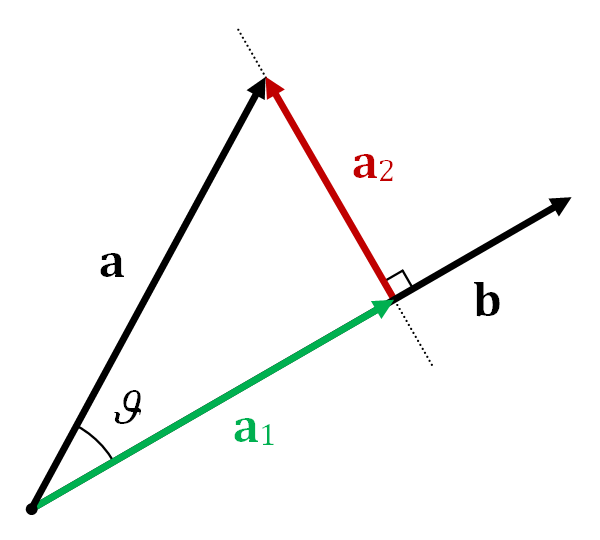

For our purposes, $\mathbf{a}$ is $\mathbf{u}$ (our advection vector), and $a_1$ represents the projection of that onto a link $b$. So we want $a_1$. The formula is

$$a_1 = ||\mathbf{a}|| \cos\theta$$,

where $\theta$ is the angle between (in our case) the advection direction and the link direction. Let's try a few examples. First, for convenience we'll say that the magnitude $||\mathbf{a}|| = 1$. Imagine we have a horizontal link, $\theta_l = 0$. Let's see what happens as we rotate the vector field around the circle (counter-clockwise?) in increments of 24 degrees:

In [ ]:
print('Angle, Projected magnitude')
for theta_adv in range(0, 361, 24):
    a1 = np.cos(np.radians(theta_adv))
    print(theta_adv, a1)

That looks right: the projection onto a horizontal (east-directed) link becomes negative when the advection direction is between 90 and 270 degrees. It approaches 1 at 180 degrees.

Let's see what happens for the other link orientations:

In [ ]:
for link_angle in [30, 60, 90, 120, -30]:
    print('\n')
    print('Link angle =', link_angle)
    for theta_adv in range(0, 361, 24):
        theta = theta_adv - link_angle
        a1 = np.cos(np.radians(theta))
        print(theta_adv, a1)

This all looks right, and implies that the operation is mathematically pretty simple, as expressed in the below function:

In [ ]:
def cartesian_to_polar(x, y):
    """Convert 2d cartesian coordinates (x, y) into polar coordinates (r, theta)"""
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

def map_vectors_to_links(grid, ux, uy, out=None):
    """Map magnitude and sign of vectors with components (ux, uy) onto grid links"""
    if out is None:
        out = np.zeros(grid.number_of_links)
    u, theta_u = cartesian_to_polar(ux, uy)
    theta = theta_u - grid.angle_of_link
    out[:] = u * np.cos(theta)
    return out

#TODO: add tests
from numpy.testing import assert_array_almost_equal
C30 = np.cos(np.radians(30))

hmg = HexModelGrid((3, 2))
link_vecs = map_vectors_to_links(hmg, 1.0, 0.0)
expected = np.array([1.0, -0.5, 0.5, -0.5, 0.5, 1.0, 1.0, 0.5, -0.5, 0.5, -0.5, 1.0])
assert_array_almost_equal(link_vecs, expected)

link_vecs = map_vectors_to_links(hmg, 0.0, 1.0)
expected = np.array([0.0, C30, C30, C30, C30, 0.0, 0.0, C30, C30, C30, C30, 0.0])
assert_array_almost_equal(link_vecs, expected)

hmg = HexModelGrid((2, 3), orientation="vertical")
link_vecs = map_vectors_to_links(hmg, 1.0, 0.0)
expected = np.array([C30, C30, 0.0, C30, C30, 0.0, 0.0, C30, C30, 0.0, C30, C30])
assert_array_almost_equal(link_vecs, expected)

link_vecs = map_vectors_to_links(hmg, 0.0, 1.0)
expected = np.array([-0.5, 0.5, 1.0, 0.5, -0.5, 1.0, 1.0, -0.5, 0.5, 1.0, 0.5, -0.5])
assert_array_almost_equal(link_vecs, expected)


#### Case of right-ward motion

In [ ]:
# Parameters
ux = 1.0
uy = 0.0
ncols = 50
nrows = int(ncols / (0.5 * 3.0**0.5))
ntimesteps = 50

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(ux, uy)

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Diagnosing the weirdness along the strip...

...when you have 100 rows and 100 columns.

Turns out to be a bug in Landlab grid setup; issue posted.

Code below probes it. Analysis and testing continued after this section.

In [ ]:
np.where(elev < -1.0)

In [ ]:
elev[2230:2240]

In [ ]:
thecell = grid.cell_at_node[2234]
grid.faces_at_cell[thecell]

In [ ]:
grid.link_at_face[grid.faces_at_cell[thecell]]

In [ ]:
grid.links_at_node[2234]

In [ ]:
def id_mismatched_faces_and_links(grid):
    for n in grid.core_nodes:
        c = grid.cell_at_node[n]
        laf = grid.link_at_face[grid.faces_at_cell[c]]
        lan = grid.links_at_node[n]
        if laf[0] != lan[0]:
            print('Node', n)
            print('Links at node:', lan)
            print('Links at faces at cell:', laf)

In [ ]:
id_mismatched_faces_and_links(grid)

In [ ]:
def repair_faces(grid):
    all_fac = grid.faces_at_cell.copy()
    for n in grid.core_nodes:
        c = grid.cell_at_node[n]
        fac = all_fac[c]
        laf = grid.link_at_face[fac]
        lan = grid.links_at_node[n]
        if laf[0] != lan[0]:
            all_fac[c,:] = np.roll(fac, 1)
    grid.faces_at_cell = all_fac

In [ ]:
## BELOW IS WHERE I AM. NEED TO FIX THE MIS-MATCH IN HEXGRID, PATCH WON'T WORK.

In [ ]:
#repair_faces(grid)
id_mismatched_faces_and_links(grid)

In [ ]:
imshow_grid(grid, elev - adv.elev0)

In [ ]:
adv.grid.links_at_node[2230:2238]

In [ ]:
vel[adv.grid.links_at_node[2230:2238]]

In [ ]:
adv.uwll[adv.grid.links_at_node[2230:2238]]

In [ ]:
# minimal example of the link-face mismatch with a HexModelGrid
from landlab import HexModelGrid
import numpy as np

nrows = 25
ncols = 25
dx = 1.0 / 99

def id_mismatched_faces_and_links(grid):
    n_mis = 0
    for n in grid.core_nodes:
        c = grid.cell_at_node[n]
        laf = grid.link_at_face[grid.faces_at_cell[c]]
        lan = grid.links_at_node[n]
        if np.any(laf != lan):
            n_mis += 1
            print('Node', n)
            print('Links at node:', lan)
            print('Links at faces at cell:', laf)
    print(n_mis, 'mismatches detected.')
            
grid = HexModelGrid((nrows, ncols), spacing=dx)
id_mismatched_faces_and_links(grid)


#### Case of upward (northward) motion

In [ ]:
# Parameters
ux = 0.0
uy = 1.0
ntimesteps = 50

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(ux, uy)

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

In [ ]:
# Parameters
ux = 0.0
uy = 1.0

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(ux, uy)

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of leftward (westward) motion

In [ ]:
# Parameters
ux = -1.0
uy = 0.0

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(abs(ux), abs(uy))

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of downward (southward) motion

In [ ]:
# Parameters
ux = 0.0
uy = -1.0

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / max(abs(ux), abs(uy))

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of nne motion

In [ ]:
# Parameters
ux = np.cos(np.degrees(60))
uy = np.sin(np.degrees(60))
u = np.sqrt(ux*ux + uy*uy)

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of nnw motion

In [ ]:
# Parameters
ux = -np.cos(np.degrees(60))
uy = np.sin(np.degrees(60))
u = np.sqrt(ux*ux + uy*uy)

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of ssw motion

In [ ]:
# Parameters
ux = -np.cos(np.degrees(60))
uy = -np.sin(np.degrees(60))
u = np.sqrt(ux*ux + uy*uy)

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case of sse motion

In [ ]:
# Parameters
ux = np.cos(np.degrees(60))
uy = -np.sin(np.degrees(60))
u = np.sqrt(ux*ux + uy*uy)

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)

#### Case with vertically oriented grid, rightward (eastward) motion

In [ ]:
# Parameters
ux = 1.0
uy = 0.0
u = np.sqrt(ux*ux + uy*uy)
nrows = 50
ncols = int(nrows / (0.5 * 3.0**0.5))

# Setup
dx = 1.0 / (max(nrows, ncols) - 1)
dt = c * dx / u

# create grid
grid = HexModelGrid((nrows, ncols), spacing=dx, node_layout="rect", orientation="vertical")

# Boundary condition
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED

# create fields
elev = grid.add_zeros('topographic__elevation', at='node')
vel = grid.add_zeros('advection__velocity', at='link')

# initialize fields
make_gaussian_bump(grid, elev, bump_width)
maxnode = np.argmax(elev)
x0 = grid.x_of_node[maxnode]
y0 = grid.y_of_node[maxnode]
map_vectors_to_links(grid, ux, uy, out=vel)

adv = TVD2dAdvector(grid)
adv.run_n_steps(ntimesteps, dt)
imshow_grid(adv.grid, adv.elev)

In [ ]:
calc_translation_distance(grid, elev, x0, y0, np.sqrt(ux*ux + uy*uy), dt, ntimesteps)